# Crime Prediction

Applying some **Data Visualization** of "crime_dataset_new.csv" to get better understanding of data.

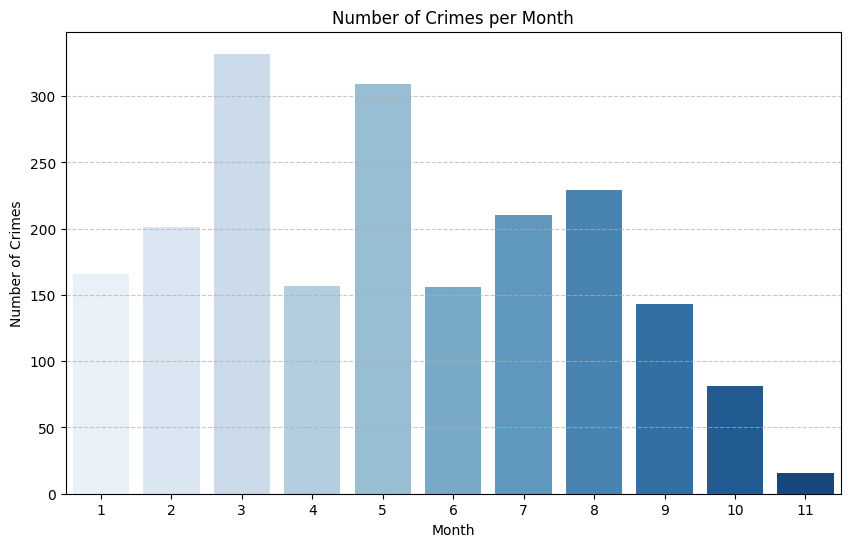

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('crime_dataset_new.csv')

# Ensure date column is in datetime format
df['start_date'] = pd.to_datetime(df['start_date'])

# 1. Crimes per Month
df['month'] = df['start_date'].dt.month
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='month', palette='Blues')
plt.title('Number of Crimes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

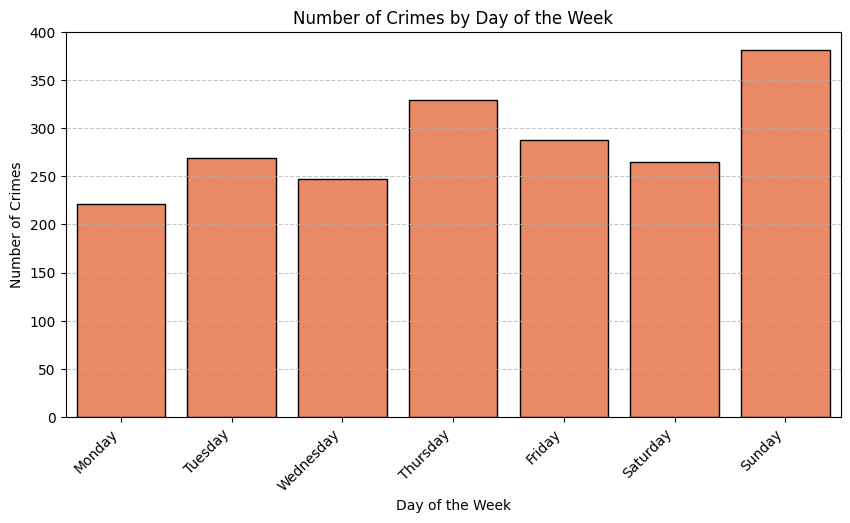

In [ ]:
# 2. Crimes by Day of the Week
df['day_of_week'] = df['start_date'].dt.day_name()
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], color='coral', edgecolor='black')
plt.title('Number of Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

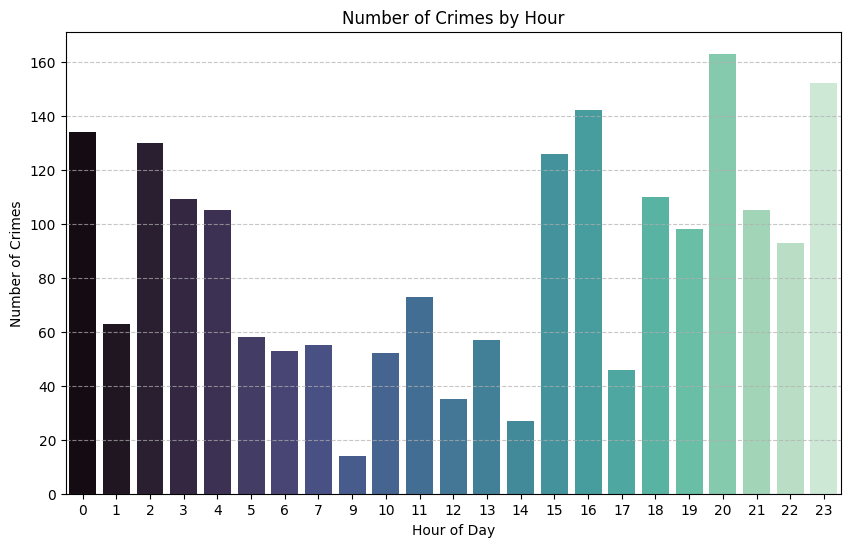

In [ ]:
# 3. Crimes by Hour
df['hour'] = df['start_date'].dt.hour
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='hour', palette='mako')
plt.title('Number of Crimes by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

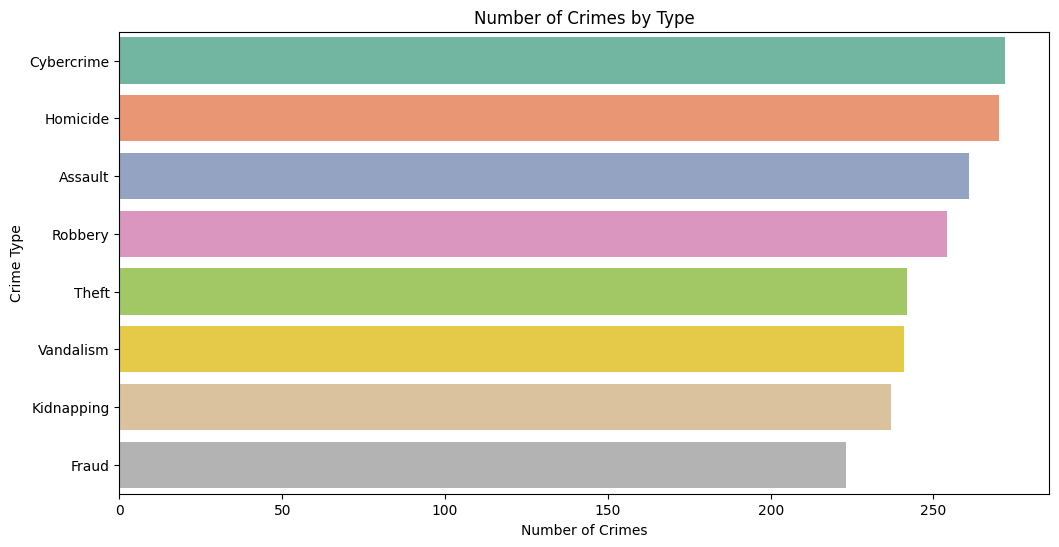

In [ ]:
# 4. Crimes by Type
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='crime_type', order=df['crime_type'].value_counts().index, palette='Set2')
plt.title('Number of Crimes by Type')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.show()

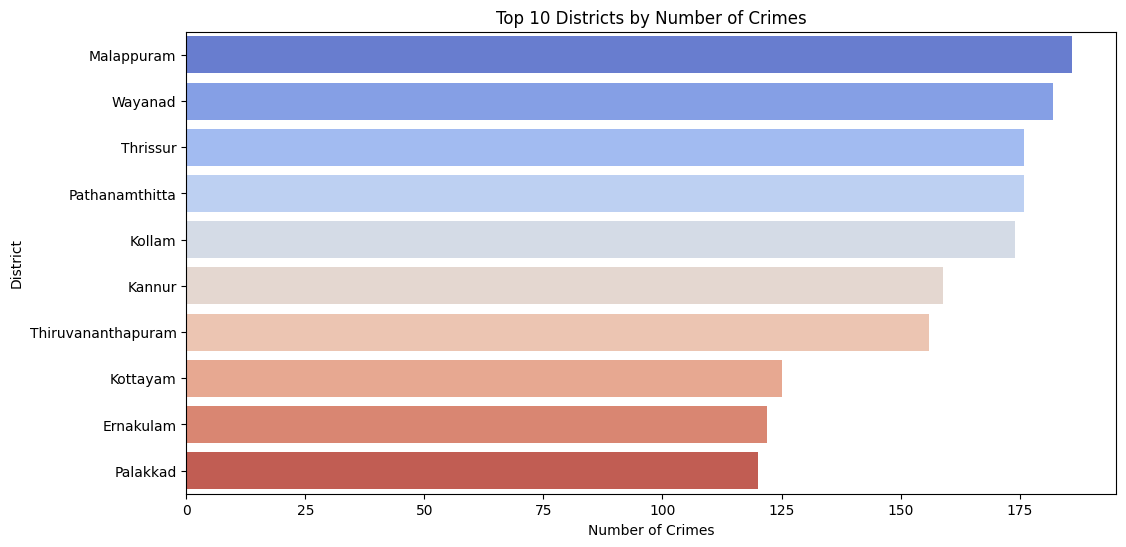

In [ ]:
# 5. Crimes by District (Top 10)
top_districts = df['district'].value_counts().nlargest(10).index
plt.figure(figsize=(12,6))
sns.countplot(data=df[df['district'].isin(top_districts)], y='district', order=top_districts, palette='coolwarm')
plt.title('Top 10 Districts by Number of Crimes')
plt.xlabel('Number of Crimes')
plt.ylabel('District')
plt.show()

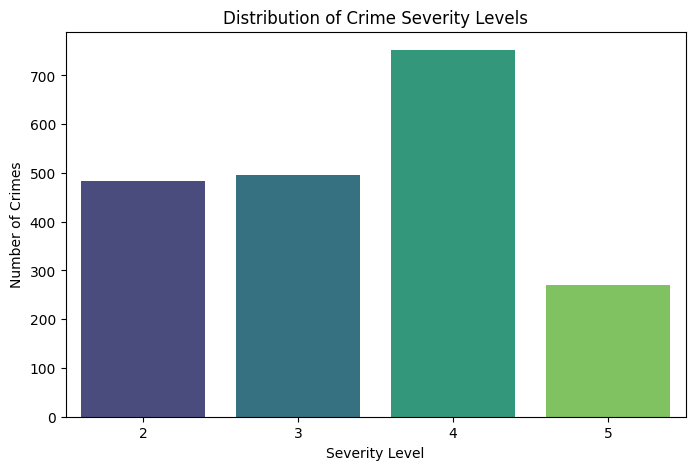

In [ ]:
# 6. Severity Level Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='severity_level', palette='viridis')
plt.title('Distribution of Crime Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Number of Crimes')
plt.show()

# Strategic Police Deployment through Temporal Prediction using Gradient Boosting Regressor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# ---------------------------
# Configuration
# ---------------------------
SEVERITY_MAP = {
    'Homicide': 5,
    'Kidnapping': 4,
    'Assault': 4,
    'Robbery': 4,
    'Cybercrime': 3,
    'Fraud': 3,
    'Theft': 2,
    'Vandalism': 2
}

**Mapping each crime type to a numerical severity score so it can be used in machine learning models.**

In [ ]:
# ---------------------------
# Load and Prepare Data
# ---------------------------
df = pd.read_csv("crime_dataset.csv", parse_dates=['start_date'], dayfirst=True)
df['severity'] = df['crime_type'].map(SEVERITY_MAP)

# Drop unmapped types
df.dropna(subset=['severity'], inplace=True)

# Time features
df['hour'] = df['start_date'].dt.hour
df['date'] = df['start_date'].dt.date
df['time_window'] = (df['hour'] // 6).astype(int)

# Aggregate to ward-date-window level
agg = df.groupby(['district', 'ward', 'date', 'time_window']).agg({
    'severity': ['max', 'count']
}).reset_index()
agg.columns = ['district', 'ward', 'date', 'time_window', 'max_severity', 'crime_count']

# Lag & trend features
agg.sort_values(by=['district', 'ward', 'date'], inplace=True)
agg['severity_lag1'] = agg.groupby(['district', 'ward'])['max_severity'].shift(1)
agg['severity_avg'] = agg.groupby(['district', 'ward'])['max_severity'].transform(lambda x: x.expanding().mean())

# Drop initial rows with NaNs
agg.dropna(inplace=True)

* **Loading the dataset.**

* **Converting start_date into datetime format.**

* **Mapping textual crime types to numerical severity values.**

* **Removing crimes that are not mapped (i.e., missing severity).**


**Extract time-based features:**

* hour is the hour of the day.

* date separates out the date from datetime.

* time_window breaks a day into 4 windows of 6 hours:

  * **0:** 00:00–05:59

  * **1:** 06:00–11:59

  * **2:** 12:00–17:59

  * **3:** 18:00–23:59

**For each (district, ward, date, time_window) combination:**

* Compute the maximum severity and number of crimes.

* This gives a higher-level summary useful for modeling.

**Add temporal features:**

* severity_lag1: previous time window's severity (for that ward).

* severity_avg: running average of max severities (trend indicator).

* dropna(): remove first rows with missing lag values.

In [ ]:
# ---------------------------
# Model Training
# ---------------------------
features = ['district', 'ward', 'time_window', 'crime_count', 'severity_lag1', 'severity_avg']
target = 'max_severity'

X = agg[features]
y = agg[target]

cat_features = ['district', 'ward']
num_features = ['time_window', 'crime_count', 'severity_lag1', 'severity_avg']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

model = Pipeline([
    ('prep', preprocessor),
    ('reg', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['district', 'ward']),
                                                 ('num', StandardScaler(),
                                                  ['time_window', 'crime_count',
                                                   'severity_lag1',
                                                   'severity_avg'])])),
                ('reg', GradientBoostingRegressor(random_state=42))])

In [ ]:
# ---------------------------
# Prediction Phase
# ---------------------------
# Use last known values per (district, ward) group for prediction
latest = agg.groupby(['district', 'ward']).last().reset_index()
latest['date'] = datetime.now().date()
latest['time_window'] = datetime.now().hour // 6

# Reuse lag and avg
latest['severity_lag1'] = latest['max_severity']
latest['severity_avg'] = latest['severity_avg']

predict_features = latest[features]
predictions = model.predict(predict_features)

# Estimate confidence as inverse of std dev of residuals per district
train_preds = model.predict(X_train)
residuals = np.abs(y_train - train_preds)

residual_df = pd.DataFrame({
    'district': X_train['district'].values,
    'residual': residuals
})

# Average residual per district (lower = higher confidence)
district_confidence = residual_df.groupby('district')['residual'].mean().reset_index()
district_confidence['confidence'] = 100 - (district_confidence['residual'] / district_confidence['residual'].max() * 100)
district_confidence.drop(columns='residual', inplace=True)

# Add predictions
latest['predicted_severity'] = predictions

# Merge confidence scores
latest = latest.merge(district_confidence, on='district', how='left')

In [ ]:
# ---------------------------
# Suggest Wards per District
# ---------------------------
suggestions = latest.sort_values(['district', 'predicted_severity'], ascending=[True, False]) \
                    .groupby('district') \
                    .first() \
                    .reset_index()

print("\n🚨 Surveillance Deployment Suggestions for next 6 hours🚨 \n")

# Sort the DataFrame in descending order by confidence
sorted_suggestions = suggestions.sort_values(by='confidence', ascending=False)

# Iterate and print with signals
for _, row in sorted_suggestions.iterrows():
    confidence = row['confidence']

    # Define signal based on confidence level
    if confidence >= 80:
        signal = "🔴"
    elif confidence >= 50:
        signal = "🟠"
    elif confidence >= 20:
        signal = "🟡"
    else:
        signal = "⚪"

    # Print the results with signals
    print(f"District: {row['district']}")
    print(f"  ➤ Deploy in Ward: {row['ward']}")
    print(f"  ➤ Predicted Crime Severity: {row['predicted_severity']:.2f}")
    print(f"  ➤ Confidence Level: {confidence:.1f}%  {signal}\n")



🚨 Surveillance Deployment Suggestions for next 6 hours🚨 

District: Kottayam
  ➤ Deploy in Ward: 5
  ➤ Predicted Crime Severity: 5.01
  ➤ Confidence Level: 63.8%  🟠

District: Kozhikode
  ➤ Deploy in Ward: 9
  ➤ Predicted Crime Severity: 4.98
  ➤ Confidence Level: 60.6%  🟠

District: Pathanamthitta
  ➤ Deploy in Ward: 1
  ➤ Predicted Crime Severity: 5.01
  ➤ Confidence Level: 59.6%  🟠

District: Ernakulam
  ➤ Deploy in Ward: 9
  ➤ Predicted Crime Severity: 5.00
  ➤ Confidence Level: 54.5%  🟠

District: Kasaragod
  ➤ Deploy in Ward: 1
  ➤ Predicted Crime Severity: 5.00
  ➤ Confidence Level: 46.7%  🟡

District: Thiruvananthapuram
  ➤ Deploy in Ward: 5
  ➤ Predicted Crime Severity: 5.00
  ➤ Confidence Level: 38.4%  🟡

District: Idukki
  ➤ Deploy in Ward: 3
  ➤ Predicted Crime Severity: 4.36
  ➤ Confidence Level: 35.9%  🟡

District: Kannur
  ➤ Deploy in Ward: 6
  ➤ Predicted Crime Severity: 5.11
  ➤ Confidence Level: 34.1%  🟡

District: Malappuram
  ➤ Deploy in Ward: 8
  ➤ Predicted Crime

**Gives a visual signal based on confidence:**

* 🔴 High confidence

* 🟠 Moderate

* 🟡 Low

* ⚪ Very low

# Integrating Maps

In [ ]:
# Install folium (Leaflet wrapper)
!pip install folium

In [2]:
# Install folium (Leaflet wrapper)
!pip install folium

import folium
import random
import json
import requests

# Reliable GeoJSON source: Geohacker repo
geojson_url = "https://raw.githubusercontent.com/geohacker/kerala/master/geojsons/district.geojson"
r = requests.get(geojson_url)
r.raise_for_status()  # ensure we got a valid response
geojson_data = r.json()  # should now parse without errors

# Create a map centered on Kerala
kerala_map = folium.Map(location=[10.85, 76.27], zoom_start=7)

# Function to generate random hex color
def get_random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

# Add each district with distinct color and tooltip
for feature in geojson_data["features"]:
    district = feature["properties"]["DISTRICT"]
    folium.GeoJson(
        feature,
        name=district,
        style_function=lambda feat, color=get_random_color(): {
            "fillColor": color,
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.5,
        },
        tooltip=district,
    ).add_to(kerala_map)

# Add a layer control panel
folium.LayerControl().add_to(kerala_map)

# Display the map in Colab
kerala_map


In [3]:
# Install folium and ipywidgets
!pip install folium ipywidgets

import folium
import json
import requests
from IPython.display import display
import ipywidgets as widgets

# Load the Kerala GeoJSON
geojson_url = "https://raw.githubusercontent.com/geohacker/kerala/master/geojsons/district.geojson"
geojson_data = requests.get(geojson_url).json()

# Extract district names
district_names = sorted([feature["properties"]["DISTRICT"] for feature in geojson_data["features"]])

# Dropdown for district selection
district_dropdown = widgets.Dropdown(
    options=district_names,
    description='District:',
    layout=widgets.Layout(width='300px')
)

# Function to create the map
def create_map(selected_district):
    kerala_map = folium.Map(location=[10.85, 76.27], zoom_start=7)

    for feature in geojson_data["features"]:
        district = feature["properties"]["DISTRICT"]
        if district == selected_district:
            style = {
                "fillColor": "#ff7800",
                "color": "black",
                "weight": 2,
                "fillOpacity": 0.6
            }
        else:
            style = {
                "fillColor": "gray",
                "color": "black",
                "weight": 0.5,
                "fillOpacity": 0.1
            }

        folium.GeoJson(
            feature,
            name=district,
            style_function=lambda feat, style=style: style,
            tooltip=district
        ).add_to(kerala_map)

    folium.LayerControl().add_to(kerala_map)
    return kerala_map

# Display initial map
out = widgets.Output()

def update_map(change):
    with out:
        out.clear_output()
        selected = district_dropdown.value
        map_obj = create_map(selected)
        display(map_obj)

# Attach the callback
district_dropdown.observe(update_map, names='value')

# Display widgets and map
display(district_dropdown)
update_map(None)  # initial render
display(out)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00


Dropdown(description='District:', layout=Layout(width='300px'), options=('Alappuzha', 'Ernakulam', 'Idukki', '…

Output()

**Placeholder code for ward data**

In [5]:
# Install folium and ipywidgets
!pip install folium ipywidgets

import folium
import json
import requests
import math
from IPython.display import display
import ipywidgets as widgets

# Load Kerala district GeoJSON
geojson_url = "https://raw.githubusercontent.com/geohacker/kerala/master/geojsons/district.geojson"
geojson_data = requests.get(geojson_url).json()

# Extract district names
district_names = sorted([feature["properties"]["DISTRICT"] for feature in geojson_data["features"]])

# Dropdown to select district
district_dropdown = widgets.Dropdown(
    options=district_names,
    description='District:',
    layout=widgets.Layout(width='300px')
)

# ➕ Coordinates to highlight (e.g., Kochi)
highlight_coords = (9.9312, 76.2673)  # (latitude, longitude)
circle_radius_m = 3000  # radius in meters

# Function to generate polygon-style circular boundary (returns list of lat/lon)
def generate_circle_boundary(lat, lon, radius_m, num_points=60):
    R = 6378137  # Earth radius in meters
    coords = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        dx = radius_m * math.cos(angle)
        dy = radius_m * math.sin(angle)
        dlat = dy / R
        dlon = dx / (R * math.cos(math.pi * lat / 180))
        coords.append((lat + dlat * 180 / math.pi, lon + dlon * 180 / math.pi))
    return coords

# Function to create the map
def create_map(selected_district):
    kerala_map = folium.Map(location=[10.85, 76.27], zoom_start=7)

    for feature in geojson_data["features"]:
        district = feature["properties"]["DISTRICT"]
        if district == selected_district:
            style = {
                "fillColor": "#ff7800",
                "color": "black",
                "weight": 2,
                "fillOpacity": 0.6
            }
        else:
            style = {
                "fillColor": "gray",
                "color": "black",
                "weight": 0.5,
                "fillOpacity": 0.1
            }

        folium.GeoJson(
            feature,
            name=district,
            style_function=lambda feat, style=style: style,
            tooltip=district
        ).add_to(kerala_map)

    # Add the center marker
    folium.Marker(
        location=highlight_coords,
        popup="Highlight Point",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(kerala_map)

    # Add a polygon circle around the point
    boundary_coords = generate_circle_boundary(*highlight_coords, circle_radius_m)
    folium.Polygon(
        locations=boundary_coords,
        color="blue",
        fill=True,
        fill_opacity=0.2,
        popup=f"{circle_radius_m}m boundary"
    ).add_to(kerala_map)

    folium.LayerControl().add_to(kerala_map)
    return kerala_map

# Output widget and interactivity
out = widgets.Output()

def update_map(change):
    with out:
        out.clear_output()
        selected = district_dropdown.value
        map_obj = create_map(selected)
        display(map_obj)

# Attach the event handler
district_dropdown.observe(update_map, names='value')

# Display dropdown and map
display(district_dropdown)
update_map(None)
display(out)

Dropdown(description='District:', layout=Layout(width='300px'), options=('Alappuzha', 'Ernakulam', 'Idukki', '…

Output()

**Integrating concept of selecting a district and selecting one of its wards.** Task: Find out the central coordinate of wards in all districts of kerala

In [11]:
# Install required packages
!pip install folium ipywidgets

import folium
import requests
from IPython.display import display
import ipywidgets as widgets

# --- Load Kerala District GeoJSON ---
geojson_url = "https://raw.githubusercontent.com/geohacker/kerala/master/geojsons/district.geojson"
geojson_data = requests.get(geojson_url).json()

# --- Dummy district-to-ward data (with coordinates) ---
district_ward_data = {
    "Thiruvananthapuram": {
        "Ward 1": (8.5241, 76.9366),
        "Ward 2": (8.5271, 76.9400),
        "Ward 3": (8.5300, 76.9450),
    },
    "Ernakulam": {
        "Ward A": (9.9816, 76.2999),
        "Ward B": (9.9900, 76.3100),
        "Ward C": (9.9950, 76.3200),
    },
    "Kozhikode": {
        "Zone 1": (11.2588, 75.7804),
        "Zone 2": (11.2600, 75.7850),
    }
}

# --- UI Elements: Dropdowns ---
district_dropdown = widgets.Dropdown(
    options=sorted(district_ward_data.keys()),
    description='District:',
    layout=widgets.Layout(width='300px')
)

ward_dropdown = widgets.Dropdown(
    options=[],
    description='Ward:',
    layout=widgets.Layout(width='300px')
)

map_output = widgets.Output()

# --- Update ward dropdown based on selected district ---
def update_wards(change):
    district = district_dropdown.value
    wards = list(district_ward_data[district].keys())
    ward_dropdown.options = wards
    ward_dropdown.value = wards[0]  # Set default ward
    update_map(None)  # Force map update for first ward

district_dropdown.observe(update_wards, names='value')

# --- Update map when ward changes ---
def update_map(change):
    map_output.clear_output()

    district = district_dropdown.value
    ward = ward_dropdown.value
    coord = district_ward_data[district][ward]

    with map_output:
        # Initialize map at ward center
        m = folium.Map(location=coord, zoom_start=12)

        # Highlight selected district boundary
        for feature in geojson_data["features"]:
            if feature["properties"]["DISTRICT"] == district:
                folium.GeoJson(
                    feature,
                    name=district,
                    style_function=lambda feat: {
                        "fillColor": "#ff7800",
                        "color": "black",
                        "weight": 2,
                        "fillOpacity": 0.4
                    },
                    tooltip=district
                ).add_to(m)

        # Add marker and circle for selected ward
        folium.Marker(
            location=coord,
            popup=f"{ward}, {district}",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

        folium.Circle(
            location=coord,
            radius=500,
            color="green",
            fill=True,
            fill_opacity=0.3
        ).add_to(m)

        folium.LayerControl().add_to(m)
        display(m)

# --- Trigger update when ward is selected manually ---
ward_dropdown.observe(update_map, names='value')

# --- Initialize UI and first render ---
update_wards(None)

# --- Display interface ---
display(widgets.VBox([district_dropdown, ward_dropdown]))
display(map_output)

Output()

**Integrating the complete idea with shortest path from each police stations to the selected ward.**

In [12]:
# Install required packages
!pip install folium ipywidgets

import folium
import requests
from IPython.display import display
import ipywidgets as widgets

# Load Kerala district GeoJSON
geojson_url = "https://raw.githubusercontent.com/geohacker/kerala/master/geojsons/district.geojson"
geojson_data = requests.get(geojson_url).json()

# Dummy ward coordinates per district
district_ward_data = {
    "Thiruvananthapuram": {
        "Ward 1": (8.5241, 76.9366),
        "Ward 2": (8.5271, 76.9400),
        "Ward 3": (8.5300, 76.9450),
    },
    "Ernakulam": {
        "Ward A": (9.9816, 76.2999),
        "Ward B": (9.9900, 76.3100),
        "Ward C": (9.9950, 76.3200),
    },
    "Kozhikode": {
        "Zone 1": (11.2588, 75.7804),
        "Zone 2": (11.2600, 75.7850),
    }
}

# Dummy police station coordinates per district
district_police_stations = {
    "Thiruvananthapuram": [
        ("PS A", 8.5120, 76.9200),
        ("PS B", 8.5305, 76.9500)
    ],
    "Ernakulam": [
        ("PS X", 9.9850, 76.2950),
        ("PS Y", 9.9700, 76.3100)
    ],
    "Kozhikode": [
        ("PS 1", 11.2500, 75.7700),
        ("PS 2", 11.2650, 75.7900)
    ]
}

# Dropdowns
district_dropdown = widgets.Dropdown(
    options=sorted(district_ward_data.keys()),
    description='District:',
    layout=widgets.Layout(width='300px')
)

ward_dropdown = widgets.Dropdown(
    options=[],
    description='Ward:',
    layout=widgets.Layout(width='300px')
)

map_output = widgets.Output()

# Update ward list based on district
def update_wards(change):
    district = district_dropdown.value
    wards = list(district_ward_data[district].keys())
    ward_dropdown.options = wards
    ward_dropdown.value = wards[0]
    update_map(None)

district_dropdown.observe(update_wards, names='value')

# Update the map
def update_map(change):
    map_output.clear_output()

    district = district_dropdown.value
    ward = ward_dropdown.value
    ward_coord = district_ward_data[district][ward]

    with map_output:
        m = folium.Map(location=ward_coord, zoom_start=12)

        # Highlight district boundary
        for feature in geojson_data["features"]:
            if feature["properties"]["DISTRICT"] == district:
                folium.GeoJson(
                    feature,
                    name=district,
                    style_function=lambda feat: {
                        "fillColor": "#ff7800",
                        "color": "black",
                        "weight": 2,
                        "fillOpacity": 0.4
                    },
                    tooltip=district
                ).add_to(m)

        # Ward center marker and circle
        folium.Marker(
            location=ward_coord,
            popup=f"{ward}, {district}",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

        folium.Circle(
            location=ward_coord,
            radius=500,
            color="green",
            fill=True,
            fill_opacity=0.3
        ).add_to(m)

        # Add police stations and draw lines to ward
        for ps_name, lat, lon in district_police_stations.get(district, []):
            ps_coord = (lat, lon)

            # Police station marker
            folium.Marker(
                location=ps_coord,
                popup=f"Police Station: {ps_name}",
                icon=folium.Icon(color="red", icon="glyphicon glyphicon-tower")
            ).add_to(m)

            # Line from police station to ward
            folium.PolyLine(
                locations=[ps_coord, ward_coord],
                color="purple",
                weight=2,
                dash_array='5'
            ).add_to(m)

        folium.LayerControl().add_to(m)
        display(m)

# Update on ward selection
ward_dropdown.observe(update_map, names='value')

# Initialize
update_wards(None)

# Display UI
display(widgets.VBox([district_dropdown, ward_dropdown]))
display(map_output)

Output()

In [14]:
# Install required packages
!pip install folium ipywidgets osmnx

import folium
import requests
import osmnx as ox
import networkx as nx
from IPython.display import display
import ipywidgets as widgets

# Load Kerala district GeoJSON
geojson_url = "https://raw.githubusercontent.com/geohacker/kerala/master/geojsons/district.geojson"
geojson_data = requests.get(geojson_url).json()

# Dummy ward and police station data
district_ward_data = {
    "Thiruvananthapuram": {
        "Ward 1": (8.5241, 76.9366),
        "Ward 2": (8.5271, 76.94),
        "Ward 3": (8.53, 76.945),
    },
    "Ernakulam": {
        "Ward A": (9.9816, 76.2999),
        "Ward B": (9.99, 76.31),
        "Ward C": (9.995, 76.32),
    },
}
district_police_data = {
    "Thiruvananthapuram": [("PS A", 8.5120, 76.92), ("PS B", 8.5305, 76.95)],
    "Ernakulam": [("PS X", 9.9850, 76.2950), ("PS Y", 9.97, 76.31)],
}

# UI elements
district_dd = widgets.Dropdown(options=list(district_ward_data), description="District:")
ward_dd = widgets.Dropdown(description="Ward:")
out = widgets.Output()

# Update ward list based on district
def update_wards(_):
    wards = list(district_ward_data[district_dd.value])
    ward_dd.options = wards
    ward_dd.value = wards[0]
    update_map(None)

district_dd.observe(update_wards, "value")

# Main map update function
def update_map(_):
    out.clear_output()
    district = district_dd.value
    ward = ward_dd.value
    ward_point = district_ward_data[district][ward]
    ps_list = district_police_data[district]

    # Create base map
    m = folium.Map(location=ward_point, zoom_start=13)

    # Build road network using OSMnx
    dist = 3000  # 3 km buffer
    G = ox.graph_from_point(ward_point, dist=dist, network_type="drive")

    # Highlight selected district boundary
    for f in geojson_data["features"]:
        if f["properties"]["DISTRICT"] == district:
            folium.GeoJson(f,
                           style_function=lambda x: {
                               "fillColor": "#ff7800",
                               "color": "black",
                               "weight": 2, "fillOpacity": 0.4},
                           tooltip=district).add_to(m)

    # Mark ward center
    folium.Marker(location=ward_point, popup=f"{ward}", icon=folium.Icon(color="blue")).add_to(m)
    folium.Circle(location=ward_point, radius=300, color="green", fill=True, fill_opacity=0.3).add_to(m)

    # Draw police stations and shortest path to ward
    for name, lat, lon in ps_list:
        ps_pt = (lat, lon)
        folium.Marker(location=ps_pt, popup=name, icon=folium.Icon(color="red")).add_to(m)

        try:
            # Find nearest nodes
            orig_n = ox.distance.nearest_nodes(G, lon, lat)
            dest_n = ox.distance.nearest_nodes(G, ward_point[1], ward_point[0])
            # Shortest path
            route = nx.shortest_path(G, orig_n, dest_n, weight="length")
            # Convert to GeoDataFrame
            route_gdf = ox.graph_to_gdfs(G.subgraph(route), nodes=False)
            for _, row in route_gdf.iterrows():
                folium.PolyLine(
                    locations=[(lat, lon) for lon, lat in row['geometry'].coords],
                    color="purple", weight=4, opacity=0.7
                ).add_to(m)
        except Exception as e:
            print(f"Error plotting route from {name}: {e}")

    folium.LayerControl().add_to(m)
    with out:
        display(m)

# Trigger map update on ward change
ward_dd.observe(update_map, "value")

# Initialize and display UI
update_wards(None)
display(widgets.VBox([district_dd, ward_dd]))
display(out)

Output()